# Decision Trees

## Graphviz

### Installing graphviz

In [ ]:
!apt install -y graphviz
!pip install graphviz

### A tree example

In [0]:
from graphviz import Digraph

styles = {
    'top': {'shape': 'ellipse', 'style': 'filled', 'color': 'lightblue'},
    'no':  {'shape': 'circle', 'style': 'filled', 'color': 'red'},
    'yes': {'shape': 'circle', 'style': 'filled', 'color': 'lightgreen'},
    'qst': {'shape': 'rect'}
}

example_tree = Digraph()

example_tree.node('top', 'Should I attend the ML lecture?', styles['top'])
example_tree.node('q1', 'Do I fulfill requirements?', styles['qst'])

example_tree.node('q2', 'Do I like CS?', styles['qst'])
example_tree.node('no1', 'No ', styles['no'])

example_tree.node('q3', 'Is the lecture early in the morning?', styles['qst'])
example_tree.node('no2', 'No ', styles['no'])

example_tree.node('no3', 'No ', styles['no'])
example_tree.node('yes', 'Yes', styles['yes'])

example_tree.edge('top', 'q1')

example_tree.edge('q1', 'q2', 'Yes')
example_tree.edge('q1', 'no1', 'No')

example_tree.edge('q2', 'q3', 'Yes')
example_tree.edge('q2', 'no2', 'No')

example_tree.edge('q3', 'no3', 'Yes')
example_tree.edge('q3', 'yes', 'No')

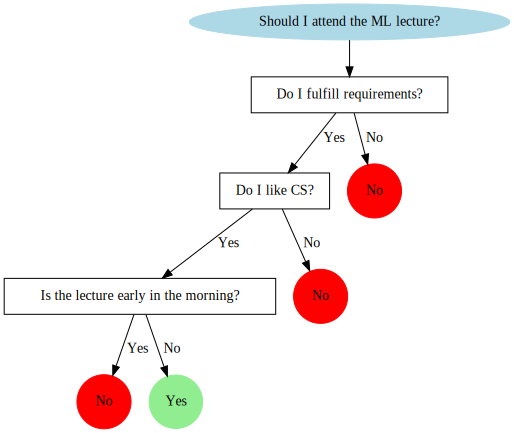

In [3]:
example_tree

## Introduction

### Decision trees

* Supervised learning algorithm - training dataset with known labels

* Eager learning - final model does not need training data to make prediction (all parameters are evaluated during learning step)

* It can do both classification and regression

* A decision tree is built from:

    * **decision nodes** - correspond to features (attributes)
    * **leaf nodes** - correspond to class labels
    
* The **root** of a tree is (should be) the best predictor (feature)


### Example

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# just to overwrite default colab style
plt.style.use('default')
plt.style.use('seaborn-talk')

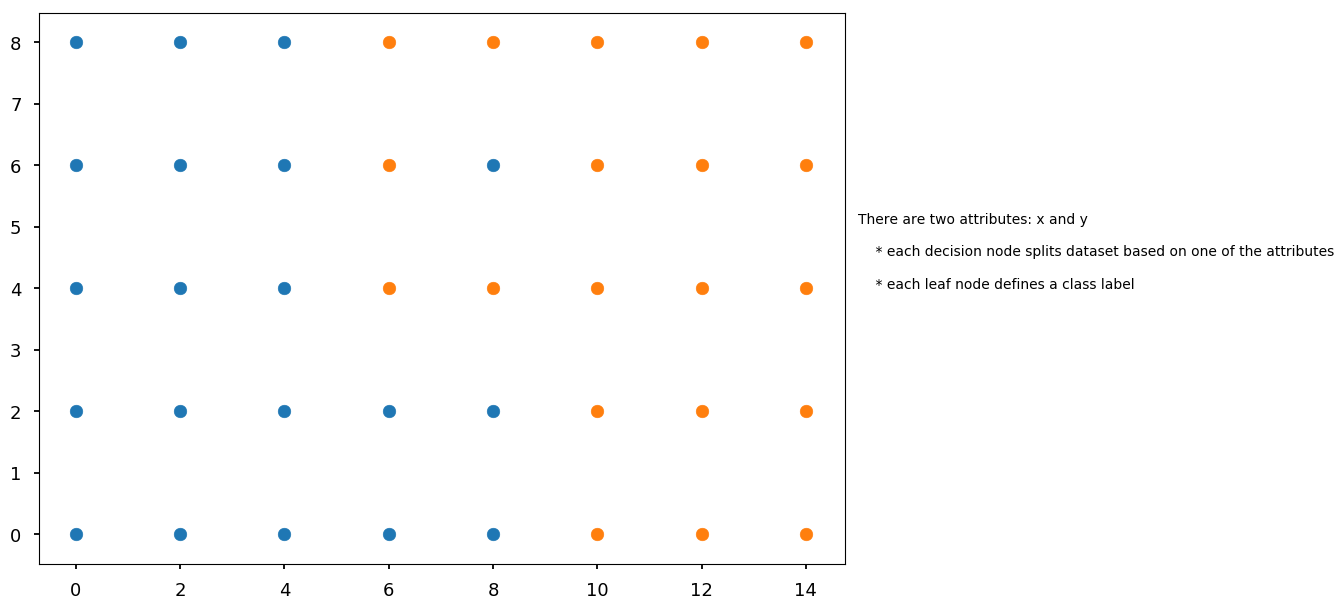

In [5]:
# first define some points representing two classes
grid = np.mgrid[0:10:2, 0:10:2]
set01 = np.vstack([grid[0].ravel(), grid[1].ravel()]).T
set01 = np.delete(set01, [17, 18, 19, 22, 24], axis=0)

grid = np.mgrid[6:16:2, 0:10:2]
set02 = np.vstack([grid[0].ravel(), grid[1].ravel()]).T
set02 = np.delete(set02, [0, 1, 5, 6, 8], axis=0)

plt.scatter(*set01.T)
plt.scatter(*set02.T)

plt.text(15, 4, "There are two attributes: x and y\n\n"
                "    * each decision node splits dataset based on one of the attributes\n\n"
                "    * each leaf node defines a class label");

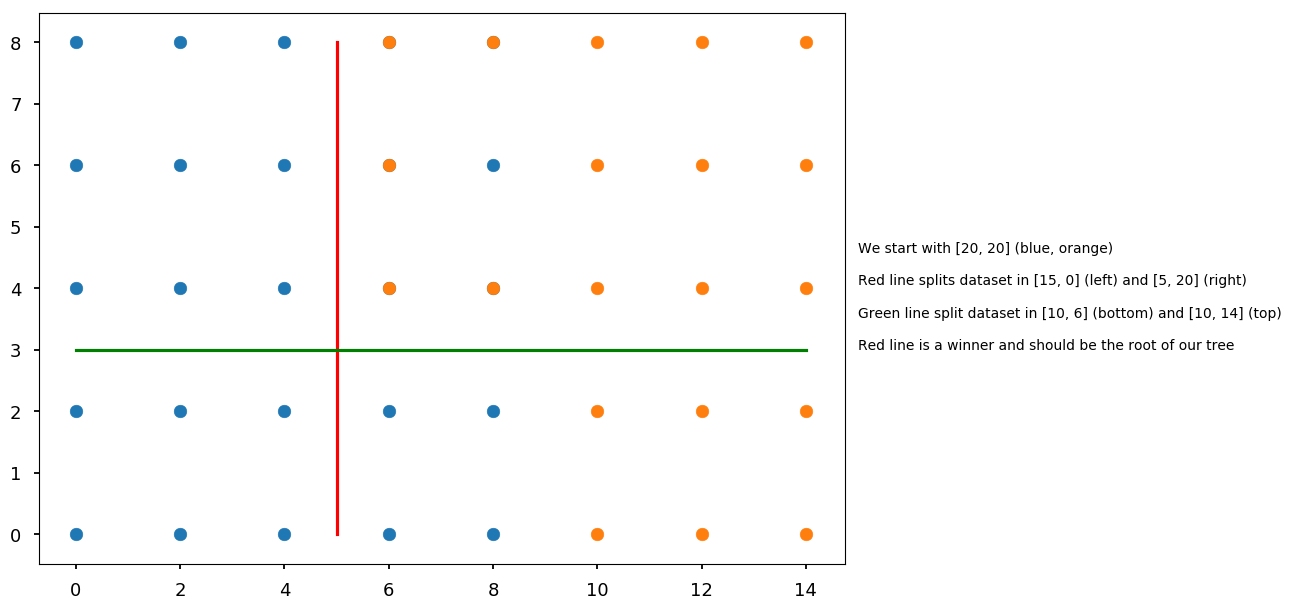

In [70]:
plt.scatter(*set01.T)
plt.scatter(*set02.T)

plt.plot([5, 5], [0, 8], 'r')
plt.plot([0, 14], [3, 3], 'g')

plt.text(15, 3, "We start with [20, 20] (blue, orange)\n\n"
                "Red line splits dataset in [15, 0] (left) and [5, 20] (right)\n\n"
                "Green line split dataset in [10, 6] (bottom) and [10, 14] (top)\n\n"
                "Red line is a winner and should be the root of our tree");

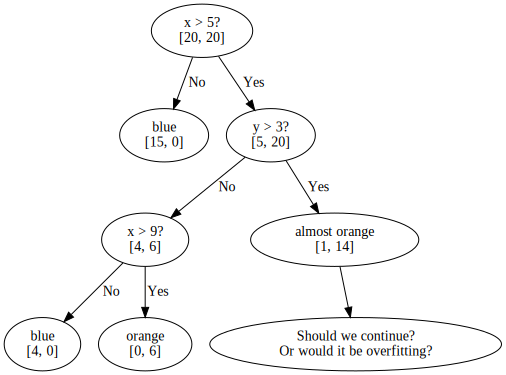

In [84]:
tree = Digraph()

tree.edge("x > 5?\n[20, 20]", "blue\n[15, 0]", "No")
tree.edge("x > 5?\n[20, 20]", "y > 3?\n[5, 20]", "Yes")

tree.edge("y > 3?\n[5, 20]", "x > 9?\n[4, 6]", "No")
tree.edge("y > 3?\n[5, 20]", "almost orange\n[1, 14]", "Yes")

tree.edge("x > 9?\n[4, 6]", "blue\n[4, 0]", "No")
tree.edge("x > 9?\n[4, 6]", "orange\n[0, 6]", "Yes")

tree.edge("almost orange\n[1, 14]", "Should we continue?\nOr would it be overfitting?")

tree

* It is important to start with good predictor

    * Our choice of the root classifies 37.5% of points  in the first step
    
    * Note, that we could also start with `x > 9?`
    
    * However, if we started with `y > 3` we would never classify a point in the first step - does it mean that it is worse choice?

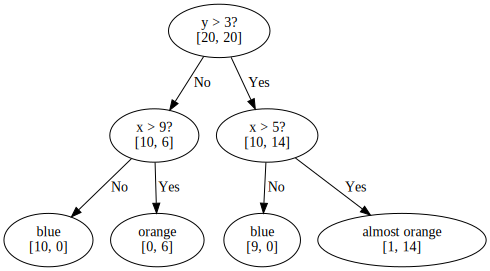

In [88]:
tree = Digraph()

tree.edge("y > 3?\n[20, 20]", "x > 9?\n[10, 6]", "No")
tree.edge("y > 3?\n[20, 20]", "x > 5?\n[10, 14]", "Yes")

tree.edge("x > 9?\n[10, 6]", "blue\n[10, 0]", "No")
tree.edge("x > 9?\n[10, 6]", "orange\n[0, 6]", "Yes")

tree.edge("x > 5?\n[10, 14]", "blue\n[9, 0]", "No")
tree.edge("x > 5?\n[10, 14]", "almost orange\n[1, 14]", "Yes")

tree

* In this case we never have to make more than 2 checks

* There are two open questions to answer:

    * How to automate the procees of chosing nodes?
    
    * How deep should we go?

## ID3 and C4.5 algorithms

* We start with algorithms based on information theory

    * ID3 (Iterative Dichotomiser 3)
    
    * C4.5 - extension of ID3 (why C4.5? C stands for programming language and 4.5 for version?)
    
    * C5.0/See5 - improved C4.5 (commercial; single-threaded Linux version is available under GPL though)
    
* The idea is to find nodes which maximize information gain

### Information gain

#### Self-information

* Let $X = (x_1, x_2, ..., x_n)$ be our *information source* (feature), e.g. weather condition: $x_1$ = sunny, $x_2$ = overcast, $x_3$ = rainy

* And let $P = (p_1, p_2, ..., p_n)$ be corresponding probrability distribution (or more precisely - probability mass function)

* We want some measure of information $I$ provided by an event. It should satisfy the following properties:

    * $I$ depends only on the probability of $x_i$, thus $I \equiv I(p_i)$
    
    * $I$ is continuous and deacreasing function of $p_i$
    
    * $I$ is non-negative and $I(1) = 0$
    
    * if $p_i = p_{i, 1} \cdot p_{i, 2}$ (independent events) then $I(p_i) = I(p_{i, 1}) + I(p_{i, 2})$
    
* Logarithmic function satisfies all above condition, so we define self-information as: <p align="center"><br>$I(p) = -\log(p)$</p><br>

    * The most common log base is **2** and then information is in **shannons (Sh)**, also known as **bits**
    
    * In the case of **natural logarithm** the unit is **nat** (natural unit of information)
    
    * In the case of base **10** the unit is **hartley (Hart)**, also known as **dit**

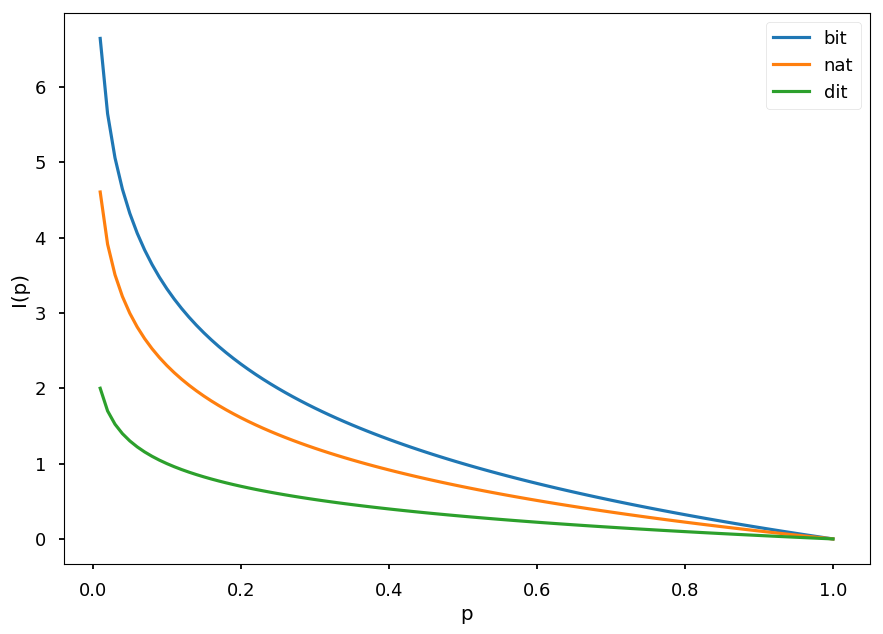

In [17]:
x = np.arange(0.01, 1.01, 0.01)

plt.xlabel("p")
plt.ylabel("I(p)")

plt.plot(x, -np.log2(x), label="bit")
plt.plot(x, -np.log(x), label="nat")
plt.plot(x, -np.log10(x), label="dit")

plt.legend();

* Lets X = (head, tail) with P = (0.5, 0.5)

    * We get 1 Sh of information

* Lets X = (sunny, overcast, rainy) with P = (0.25, 0.75, 0.25)

    * If it is overcast, we get 0.415 Sh of information
    
    * Otherwise, we get 2 Sh of information
    
* If an event is more likely we learn less

#### Information entropy

* Also called Shannon entropy (after the father of intromation theory)

* Usually information entropy is denoted as $H$

* $H$ is defined as the weighted average of the self-information of all possible outcomes <p align="center"><br>$H(X) = \sum\limits_{i=1}^N p_i \cdot I(p_i) = -\sum\limits_{i=1}^N p_i\cdot\log(p_i)$</p><br>

* Lets consider two case scenario with $P = (p, 1 - p)$, so entropy is given by $H = -p \log(p) - (1 - p) \log(1 - p)$

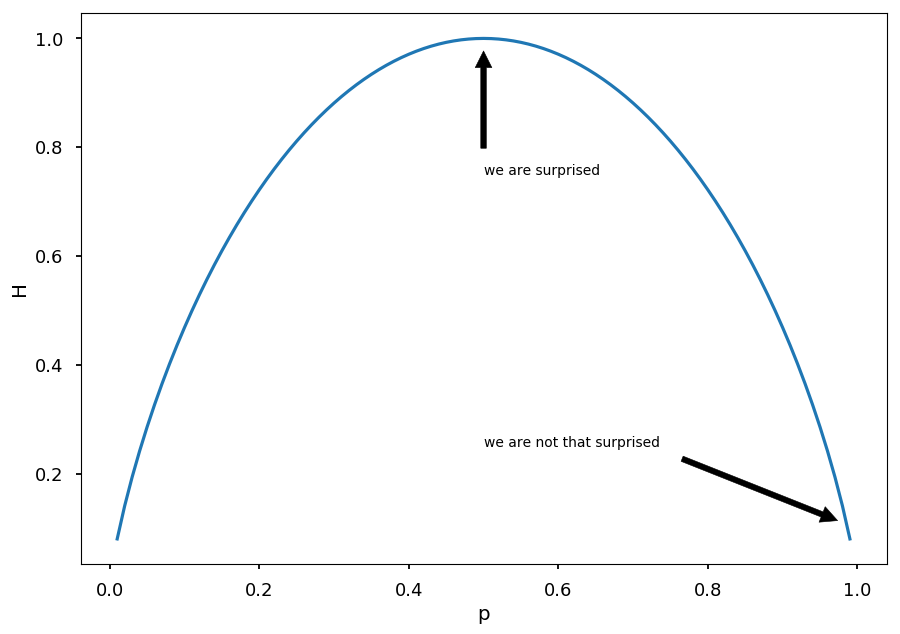

In [62]:
p = np.arange(0.01, 1.0, 0.01)

plt.xlabel("p")
plt.ylabel("H")

plt.annotate('we are surprised', xy=(0.5, 1), xytext=(0.5, 0.75),
             arrowprops=dict(facecolor='black', shrink=0.1))

plt.annotate('we are not that surprised', xy=(1, 0.1), xytext=(0.5, 0.25),
             arrowprops=dict(facecolor='black', shrink=0.1))

plt.plot(p, -p * np.log2(p) - (1 - p) * np.log2(1 - p));

* Lets consider three case scenario with $P = (p, q, 1 - p - q)$, so entropy is given by $H = -p \log(p) - q\log(q) - (1 - p - q) \log(1 - p - q)$

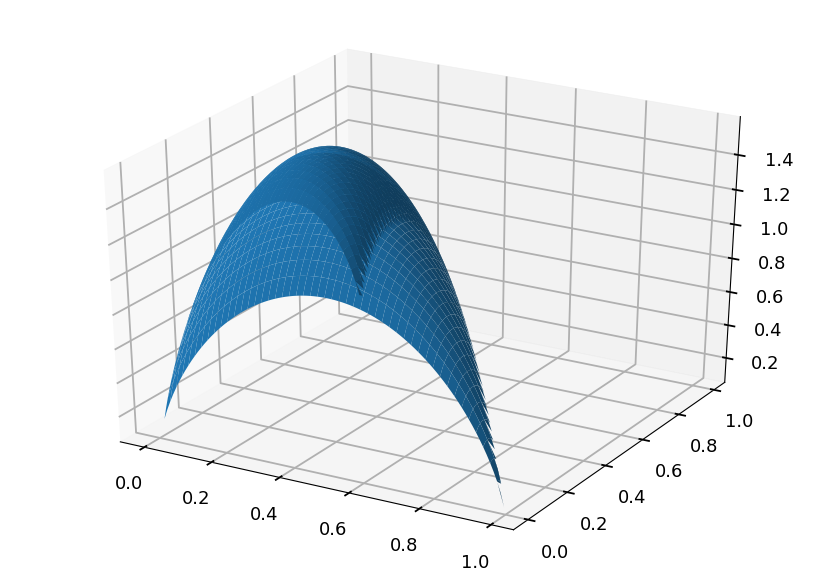

In [77]:
from mpl_toolkits import mplot3d

# grid of p, q probabilities
p, q = np.meshgrid(np.arange(0.01, 1.0, 0.01), np.arange(0.01, 1.0, 0.01))

# remove (set to 0) points which do not fulfill P <= 1
idx = p + q > 1
p[idx] = 0
q[idx] = 0

# calculate entropy (disable warnings - we are aware of log(0))
np.warnings.filterwarnings('ignore')
h = -p * np.log2(p) - q * np.log2(q) - (1 - p - q) * np.log2(1 - p - q)

# make a plot
plt.axes(projection='3d').plot_surface(p, q, h);

#### Information gain

* Let $T$ be the set of training samples with $n$ possible outcomes, thus $T = \{T_1, T_2, ..., T_n\}$

* The entropy is given by <p align="center"><br>$H(T) = -\sum\limits_{i=1}^N p_i\cdot\log(p_i) = -\sum\limits_{i=1}^N \frac{|T_i|}{|T|}\cdot\log(\frac{|T_i|}{|T|})$</p><br>
    
* We can also calulate the entropy after $T$ was partitioned in $T_i$ with respect to some feature $X$ <p align="center"><br>$H(T, X) = \sum\limits_{i=1}^N p_i\cdot H(T_i)$</p>

* And the information gain is defined as <p align="center"><br>$G(X) = H(T) - H(T, X)$</p>

##### Example

* Lets calculate some example step by step

* Lets consider a fake dataset

    * two classes: C01, C02
    
    * three features: X1, X2, X3

```
   X1  ||  A  |  A  |  A  |  B  |  B  |  C  |  C  |  C  |  C  |
---------------------------------------------------------------
   X2  ||  0  |  0  |  1  |  1  |  0  |  1  |  1  |  1  |  0  |
---------------------------------------------------------------
   X3  || RED | GRN | GRN | BLU | RED | GRN | BLU | RED | GRN |
===============================================================
 Class || C01 | C01 | C02 | C02 | C02 | C02 | C01 | C01 | C02 |
```

In [11]:
from math import log

def entropy(*probs):
  """Calculate information entropy"""
  try:
    total = sum(probs)
    return sum([-p / total * log(p / total, 2) for p in probs])
  except:
    return 0

print(entropy(4, 5), entropy(2, 1), entropy(2, 2))

0.9910760598382222 0.9182958340544896 1.0


* The *root* entropy

    * We have 9 samples: 4 belong to class C01 and 5 to C02 <p align="center"><br>$H(T) = -\frac{4}{9}\log(\frac{4}{9}) - \frac{5}{9}\log(\frac{5}{9}) = 0.99$</p><br>
    
* Now lets consider feature X1, which splits data into subsets $T_1$, $T_2$, and $T_3$ (with X1 value A, B, and C, respectively)<br><br>

    * Within $T_1$ there are 3 samples: 2 from C01 and 1 from C02 <p align="center"><br>$H(T_1) = -\frac{2}{3}\log(\frac{2}{3}) - \frac{1}{3}\log(\frac{1}{3}) = 0.92$</p><br>
    
    * Within $T_2$ there are 2 samples: 0 from C01 and 2 from C02 <p align="center"><br>$H(T_2) = -\frac{2}{2}\log(\frac{2}{2}) - \frac{0}{2}\log(\frac{0}{2}) = 0.00$</p><br>
    
    * Within $T_3$ there are 4 samples: 2 from C01 and 2 from C02 <p align="center"><br>$H(T_3) = -\frac{2}{4}\log(\frac{2}{4}) - \frac{2}{4}\log(\frac{2}{4}) = 1.00$</p><br>
    
    * The resulting entropy is <p align="center"><br>$H(T, X1) = \frac{3}{9}\cdot H(T_1) + \frac{2}{9}\cdot H(T_2) + \frac{4}{9}\cdot H(T_3) = 0.75$</p><br>
    
    * Thus, infromation gain if the set is split according to X1 <p align="center"><br>$G(X1) = H(T) - H(T, X1) = 0.99 - 0.75 = 0.24 \mbox{ Sh }$</p><br>

### ID3 algorithm

* For every attribute (feature) calculate the entropy

* Split the training set using the one for which information gain is maximum

* Continue recursively on subsets using remaining features

### Play Golf dataset

* Popular dataset to explain decision trees

* 4 features:

    * **outlook**: *rainy, overcast, sunny*
    
    * **temperature**: *cool, mild, hot*
    
    * **humidity**: *normal, high*
    
    * **windy**: *false, true*
    
* Possible outcomes (play golf?):

    * **false**
    
    * **true**

In [0]:
import pandas as pd

# first row = headers
src = "http://chem-eng.utoronto.ca/~datamining/dmc/datasets/weather_nominal.csv"

golf_data = pd.read_csv(src)

In [82]:
golf_data

,Outlook,Temperature,Humidity,Windy,Play golf
0,Rainy,Hot,High,False,No
1,Rainy,Hot,High,True,No
2,Overcast,Hot,High,False,Yes
3,Sunny,Mild,High,False,Yes
4,Sunny,Cool,Normal,False,Yes
5,Sunny,Cool,Normal,True,No
6,Overcast,Cool,Normal,True,Yes
7,Rainy,Mild,High,False,No
8,Rainy,Cool,Normal,False,Yes
9,Sunny,Mild,Normal,False,Yes


#### Play golf entropy

In [87]:
entropy(9, 5)

0.9402859586706309

```
| Play golf |
=============
| yes | no  |  -> H(T) = 0.94
-------------
|  9  |  5  |
```

#### Play golf vs outlook

```
                   | Play golf |
                   =============
                   | yes | no  |
        ------------------------
        | sunny    |  3  |  2  |  5
outlook | overcast |  4  |  0  |  4
        | rainy    |  2  |  3  |  5
        ------------------------
                      9     5
```

In [89]:
entropy(3, 2), 0, entropy(2, 3)

(0.9709505944546686, 0, 0.9709505944546686)

<br>

<p align="center">
\begin{eqnarray}
   H(\mbox{sunny}) & = & 0.97 \\
   H(\mbox{rainy}) & = & 0.97 \\
H(\mbox{overcast}) & = & 0
\end{eqnarray}
</p>

<br>

---

<br>

<p align="center">
\begin{eqnarray}
H(T, \mbox{outlook}) & = & P(\mbox{sunny})\cdot H(\mbox{sunny}) + P(\mbox{overcast})\cdot H(\mbox{overcast}) + P(\mbox{rainy})\cdot H(\mbox{rainy}) \\
                     & = & \frac{5}{14}\cdot 0.97 + \frac{4}{14} \cdot 0 + \frac{5}{14}\cdot 0.97 = 0.69
\end{eqnarray}
</p>

<br>

---

<br>

<p align="center">
\begin{eqnarray}
G(\mbox{outlook}) & = & H(T) - H(T, \mbox{outlook}) = 0.94 - 0.69 = 0.25
\end{eqnarray}
</p>

<br>

#### Results for all features

```
                    | Play golf |                         | Play golf |
                    =============                         =============
                    | yes | no  |                         | yes | no  |
         ------------------------                 --------------------
         | sunny    |  3  |  2  |                 | hot   |  2  |  2  |
 outlook | overcast |  4  |  0  |     temperature | mild  |  4  |  2  |
         | rainy    |  2  |  3  |                 | cool  |  3  |  1  |
         ------------------------                 --------------------
            Info. gain = 0.25                       Info gain = 0.03


                    | Play golf |                         | Play golf |
                    =============                         =============
                    | yes | no  |                         | yes | no  |
         ------------------------                 --------------------
         | high     |  3  |  4  |                 | false |  6  |  2  |
humidity | normal   |  6  |  1  |           windy | true  |  3  |  3  |
         ------------------------                 --------------------
            Info. gain = 0.15                       Info gain = 0.05
            

```

#### Root of the tree

* Start building a tree with the feature with the largest information gain: **outlook**

* A branch with **entropy 0** is a leaf node: **overcast**

* Other branches must be spliited using other features 

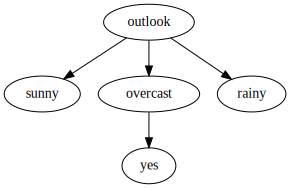

In [111]:
tree = Digraph()

tree.edge("outlook", "sunny")
tree.edge("outlook", "overcast")
tree.edge("outlook", "rainy")

tree.edge("overcast", "yes")

tree

#### Next branch

In [95]:
golf_data.loc[golf_data['Outlook'] == "Sunny"]

,Outlook,Temperature,Humidity,Windy,Play golf
3,Sunny,Mild,High,False,Yes
4,Sunny,Cool,Normal,False,Yes
5,Sunny,Cool,Normal,True,No
9,Sunny,Mild,Normal,False,Yes
13,Sunny,Mild,High,True,No


* In general, one should calculate information gain for each feature for this subset

* In this case it is clear that we can take **windy** 

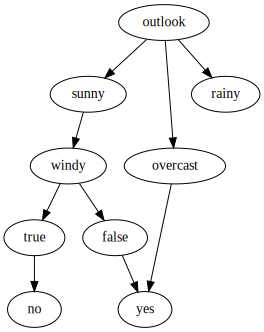

In [112]:
tree.edge("sunny", "windy")

tree.edge("windy", "false")
tree.edge("windy", "true")

tree.edge("false", "yes")
tree.edge("true", "no")

tree

#### Last branch

In [99]:
golf_data.loc[golf_data['Outlook'] == "Rainy"]

,Outlook,Temperature,Humidity,Windy,Play golf
0,Rainy,Hot,High,False,No
1,Rainy,Hot,High,True,No
7,Rainy,Mild,High,False,No
8,Rainy,Cool,Normal,False,Yes
10,Rainy,Mild,Normal,True,Yes


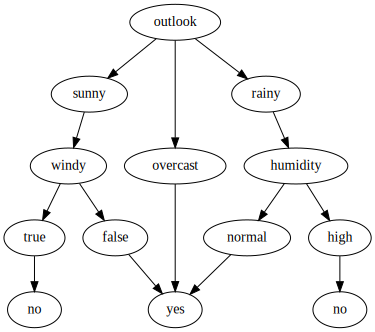

In [113]:
tree.edge("rainy", "humidity")

tree.edge("humidity", "high")
tree.edge("humidity", "normal")

tree.edge("normal", "yes")
tree.edge("high", "no ")

tree

#### Summary

* We got the final tree for Play Golf dataset using ID3 algorithm

* We do not even use temperature attribute (for which information gain was 0.03)

* The main problem is that the algorithm may overfit easily (tree does not stop growing until the whole training set is classified)

    * Imagine some crazy guys went playing on a **rainy**, **windy** day with **high humidity**, beacaue it was still **hot**
    
    * With this extra data point we would have to create more branches
    
    * Is one unique data sample worth to extend the whole tree?

* And there is more disadvantages:

    * It handles only discrete attributes

    * There is a strong bias for features with many possible outcomes

    * And finally, it does not handle missing values

### C4.5 algorithm

* C4.5 introduces some improvements to ID3:

    * continuous values using threshold
    
    * tree pruning to avoid overfitting
    
    * normalized information gain
    
    * missing values


#### Information gain ratio

* To avoid a bias in favor of features with a lot of different values C4.5 uses information gain ratio instead of information gain

* Lets define intrinsic value $V$ of an attribute $X$ as <p align="center">$V(X) = -\sum\limits_{i=1}^N \frac{|T_i|}{|T|}\cdot\log(\frac{|T_i|}{|T|})$</p>

* where $T_i$ are samples corresponding to $i$-th possible value of $X$ feature

* Information gain ratio $R(X)$ is defined as <p align="center">$R(X) = \frac{G(X)}{V(X)}$</p>

##### Example

* Lets consider a fake data set

* The goal is to determine if someone plays or not video games

* We have three features:

    * name - mostly unique
    
    * sex - 50% females and 50% males 
    
    * age - just old or young
    
* Looking at data we can say that

    * most young people play video games, why old people don't
    
    * sex does not matter
    
    * names are almost distinct

```
     name   ||  John  |  Mark  |  Anne  |  Adam  |  John  |  Alex  |  Alex  |  Xena  |  Tina  |  Lucy  |
--------------------------------------------------------------------------------------------------------
     sex    ||   M    |   M    |   F    |   M    |   M    |   F    |   M    |   F    |   F    |   F    |
--------------------------------------------------------------------------------------------------------
     age    ||  old   | young  |  old   | young  | young  | young  |  old   |  old   | young  | young  |
========================================================================================================
 play games ||   N    |   Y    |   Y    |   Y    |   Y    |   N    |   N    |   N    |   Y    |   Y    |
```

* Information gain for **name**

In [12]:
h = entropy(4, 6)  # dataset entropy H(T)

# one John plays and the other one doesn't
# in other cases entropy = 0
g_name = h - 2/10 * entropy(1, 1)

print(g_name)

0.7709505944546686


* Information gain for **sex**

In [13]:
# 5 men - 3 play
# 5 women - 3 play
g_sex = h - 5/10 * entropy(2, 3) - 5/10 * entropy(2, 3)

print(g_sex)

0.0


* Information gain for **age**

In [14]:
# 4 old people - 1 plays
# 6 young people - 5 play
g_age = h - 4/10 * entropy(1, 3) - 6/10 * entropy(1, 5)

print(g_age)

0.256425891682003


* In ID3 a feature with entropy = 0 is always a winner

    * Imagine having all distinct values (e.g. credit card numbers)

* In this case we would choose **name** as the best predictor

    * Creating a tree with 8 branches (from 10 samples)

    * Training data would be perfectly classify

    * But it is unlikely that the algorithm would be able to generalize for unseen data

* Lets calculate information gain ratio and see how it changes the choice of the best feature

* Information gain ratio for **name**

In [15]:
# 2x John, 2x Alex, 6x unique name 
g_name / entropy(2, 2, *[1]*6)

0.26384995435159336

* Information gain ratio for **sex**

In [16]:
# 5 males and 5 females - zero stays zero though
g_sex / entropy(5, 5)

0.0

* Information gain ratio for **age**

In [17]:
# 4x old and 6x young
g_age / entropy(4, 6)

0.26409777505314147

* Based on information gain ratio we choose **age** as the best predictor

* Because the denominator in a ratio penalizes features with many values

In [18]:
print("Two possible values:\n")

for i in range(0, 11):
  print("\t({}, {}) split -> entropy = {}".format(i, 10-i, entropy(i, 10-i)))

print("\n10 possible values:", entropy(*[1]*10))


Two possible values:

	(0, 10) split -> entropy = 0
	(1, 9) split -> entropy = 0.4689955935892812
	(2, 8) split -> entropy = 0.7219280948873623
	(3, 7) split -> entropy = 0.8812908992306927
	(4, 6) split -> entropy = 0.9709505944546686
	(5, 5) split -> entropy = 1.0
	(6, 4) split -> entropy = 0.9709505944546686
	(7, 3) split -> entropy = 0.8812908992306927
	(8, 2) split -> entropy = 0.7219280948873623
	(9, 1) split -> entropy = 0.4689955935892812
	(10, 0) split -> entropy = 0

10 possible values: 3.321928094887362


* This datset was handcrafted to make a point, but I hope the message is still clear

#### Continuous values

* Attributes with continuous valus must be first discretize

* The best way is to find an optimal threshold which splits the set

* The optimal threshold is the one which maximize the infromation gain

##### Example

* Lets consider the same example as before

* But this time age has numerical values

```
     name   ||  John  |  Mark  |  Anne  |  Adam  |  John  |  Alex  |  Alex  |  Xena  |  Tina  |  Lucy  |
--------------------------------------------------------------------------------------------------------
     sex    ||   M    |   M    |   F    |   M    |   M    |   F    |   M    |   F    |   F    |   F    |
--------------------------------------------------------------------------------------------------------
     age    ||   50   |   18   |   65   |   24   |   31   |   18   |   50   |   50   |   24   |   31   |
========================================================================================================
 play games ||   N    |   Y    |   Y    |   Y    |   Y    |   N    |   N    |   N    |   Y    |   Y    |
```

* The possible thesholds are therefore $\{18, 24, 31, 50\}$

In [19]:
# calculate entropy for all possible thresholds
e18 = 2/10 * entropy(1, 1) + 8/10 * entropy(3, 5)
e24 = 4/10 * entropy(1, 3) + 6/10 * entropy(3, 3)
e31 = 6/10 * entropy(1, 5) + 4/10 * entropy(3, 1)
e50 = 9/10 * entropy(4, 5) + 1/10 * entropy(0, 1)

print("With threshold = {}, entropy = {}".format(18, e18))
print("With threshold = {}, entropy = {}".format(24, e24))
print("With threshold = {}, entropy = {}".format(31, e31))
print("With threshold = {}, entropy = {}".format(50, e50))

With threshold = 18, entropy = 0.963547202339972
With threshold = 24, entropy = 0.9245112497836532
With threshold = 31, entropy = 0.7145247027726656
With threshold = 50, entropy = 0.8919684538544


* The best test is `if age > 31`

    * it splits the dataset to 6 samples (with 5 players) and 4 samples (with 3 non-players)
    
* Please note, that the best threshold may change once a node is created

#### Unknown parameters

* In the case some samples are incomplete one needs to correct the information gain

* The information gain is calculated as before for samples with known attributes

* But then it is normalized with respect to the probability that the given attribute has known values

* Lets define the factor $F$ as the ratio of the number of samples with known value for a given feature to the number of all samples in a dataset

* Then information gain is defines as <p align="center">$G(X) = F\cdot (H(T) - H(T, X))$</p>

* Please note, that $F = 1$ if all values are known

* Otherwise, information gain is scaled accordingly

#### Pruning

* The algorithm creates as many nodes as needed to classify all test samples

* It may lead to overfitting and the resulting tree would fail to classify correctly unseen samples

* To avoid this one can prune a tree

    * pre-pruning (early stopping)
    
        * stop building a tree before leaves with few samples are produced
        
        * how to decide when it is good time to stop? e.g. using cross-validation on validation set (stop if the error does not increase significantly)
        
        * underfitting if stop to early
        
    * post-pruning
    
        * let a tree grow completely
        
        * then go from bottom to top and try to replace a node with a leaf
        
        * if there is improvement in accuracy - cut a tree
        
        * if the accuracy stays the same - cut a tree (Occam's razor)
        
        * otherwise leave a node   
      

### First example - step by step

* Lets consider the problem from the beginning of the lecture

* Our dataset has 20 blue points and 20 orange points

* Each point has two features (both are numerical)

* We expect overfitting if pruning is not applied

* We will calculate everything step by step (it is boring, but demonstrates how the algorithm works)

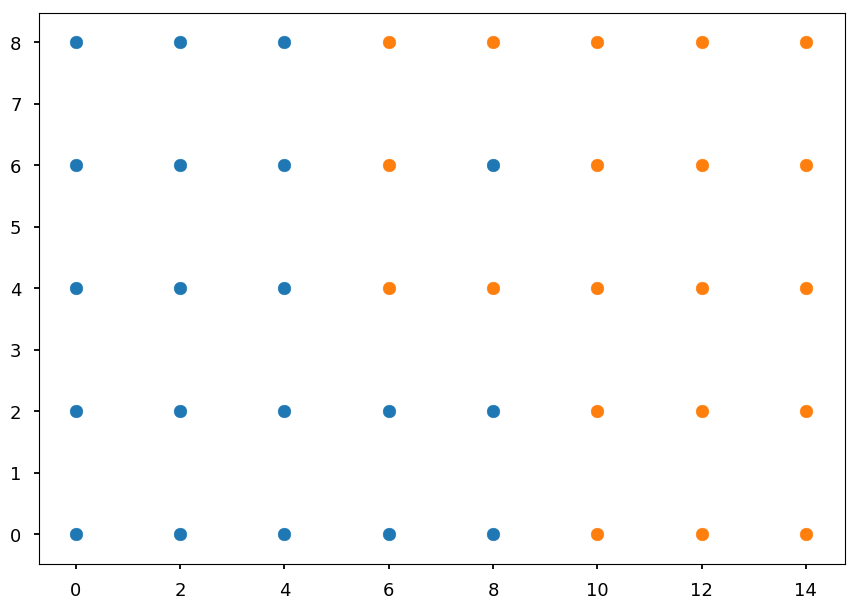

In [5]:
# first define some points representing two classes
grid = np.mgrid[0:10:2, 0:10:2]
set01 = np.vstack([grid[0].ravel(), grid[1].ravel()]).T
set01 = np.delete(set01, [17, 18, 19, 22, 24], axis=0)

grid = np.mgrid[6:16:2, 0:10:2]
set02 = np.vstack([grid[0].ravel(), grid[1].ravel()]).T
set02 = np.delete(set02, [0, 1, 5, 6, 8], axis=0)

plt.scatter(*set01.T)
plt.scatter(*set02.T);

#### Validation set

* We will use 10 points from the dataset for validation

* This time selected manually to perform by hand calculations

* On the plot below X denotes validation samples

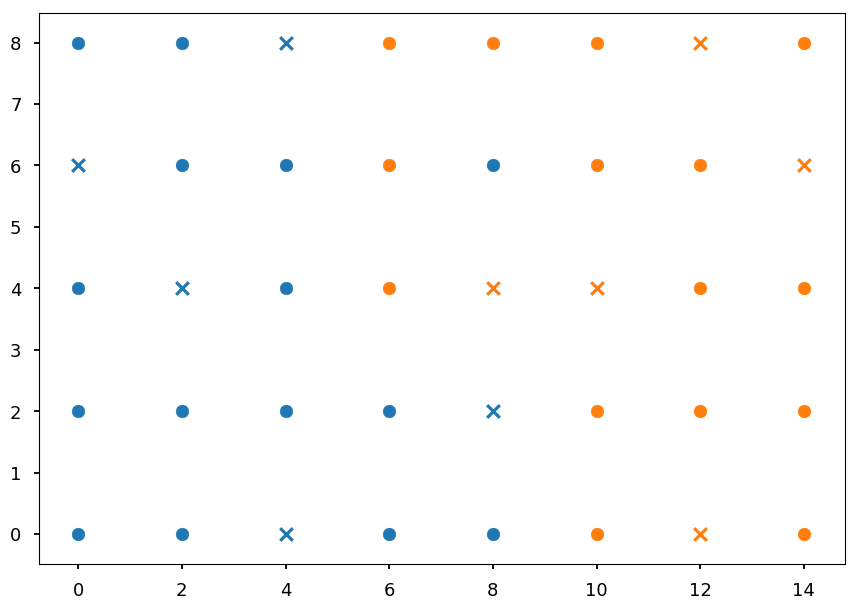

In [6]:
# split dataset to training and validation set
# note, we should splt them randomly
# but here we do this by hand
valid_idx = [3, 7, 10, 14, 18]

blue_valid = set01[valid_idx]
blue_train = np.delete(set01, valid_idx, axis=0)

orange_valid = set02[valid_idx]
orange_train = np.delete(set02, valid_idx, axis=0)

# circles - training set
# x - validation set
plt.scatter(*blue_train.T)
plt.scatter(*blue_valid.T, color='C0', marker='x')
plt.scatter(*orange_train.T)
plt.scatter(*orange_valid.T, color='C1', marker='x');

#### Thresholds finder

* When building a tree we need to calculate information gain for every threshold in current subset

* Every subset $S$ has $N_b$ blue samples and $N_o$ orange samples

* After split into accoring to some threshold we get two subsets

    * $n_b$ of blue points and $n_o$ of orange points ($S_1$)
    
    * $N_b - n_b$ of blue points and $N_o - n_o$ of orange points ($S_2$)
    


In [0]:
def info_gain(Nb, No, nb, no):
  """Calculate information gain for given split"""
  h = entropy(Nb, No) # H(S)
  total = Nb + No     # total number of samples
  subtotal = nb + no  # number of samples in subset
  
  return h - subtotal / total * entropy(nb, no) \
           - (total - subtotal) / total * entropy(Nb - nb, No - no)

#### Feature X

* We need to calculate information gain ratio for the best threshold (the one that maximize information gain)

* Possible thresholds $\{0, 2, 4, 6, 8, 10, 12\}$

In [74]:
Nb = 15
No = 15

splits = {"0": (4, 0), "2 ": (8, 0), "4": (11, 0), "6": (13, 3),
          "8": (15, 4), "10": (15, 8), "12": (15, 11)}

for threshold, (no, nb) in splits.items():
  print("Threshold = {}\t -> {}".format(threshold, info_gain(Nb, No, no, nb)))

Threshold = 0	 -> 0.14818913558232172
Threshold = 2 	 -> 0.33824492595034883
Threshold = 4	 -> 0.5297578726233217
Threshold = 6	 -> 0.3525728312615027
Threshold = 8	 -> 0.5297578726233217
Threshold = 10	 -> 0.28538113149388267
Threshold = 12	 -> 0.14818913558232172


* We got the same cuts as predicted at the beginning of the lecture: $x > 4$ or $x > 8$

* Lets choose $x > 4$ and calculate information gain ratio

In [75]:
# 4 samples with x = 0, 4 samples with x = 2 etc
info_gain(Nb, No, *splits["4"]) / entropy(4, 4, 3, 5, 3, 4, 3, 4)

0.1779055922617179

#### Feature Y

* Repeat the procedure

* This time possible thresholds = $\{0, 2, 4, 6\}$

In [77]:
Nb = 15
No = 15

splits = {"0": (4, 2), "2": (8, 5), "4": (10, 8), "6": (13, 11)}

for threshold, (no, nb) in splits.items():
  print("Threshold = {}\t -> {}".format(threshold, info_gain(Nb, No, no, nb)))

Threshold = 0	 -> 0.02035297064032593
Threshold = 2	 -> 0.029594041354123246
Threshold = 4	 -> 0.013406861436605633
Threshold = 6	 -> 0.0203529706403259


* The best cut is $y > 2$ (as predicted before)

* Lets calculate information gain ratio

In [78]:
info_gain(Nb, No, *splits["2"]) / entropy(6, 7, 5, 6, 6)

0.01278981522839263

#### The root

* At the beginning we discussed the choice of $y$ as a root predictor

* ID3 and C4.5 are greedy algorithms and select optimal solution at given stage

* We can start to build the tree with the first best predictor

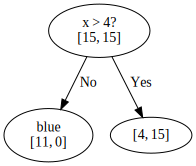

In [80]:
tree = Digraph()

tree.edge("x > 4?\n[15, 15]", "blue\n[11, 0]", "No")
tree.edge("x > 4?\n[15, 15]", "[4, 15]", "Yes")

tree

#### Branch x > 4

* Now we have to repeat the procedure for the branch $[4, 15]$

* Lets take a look what points are left

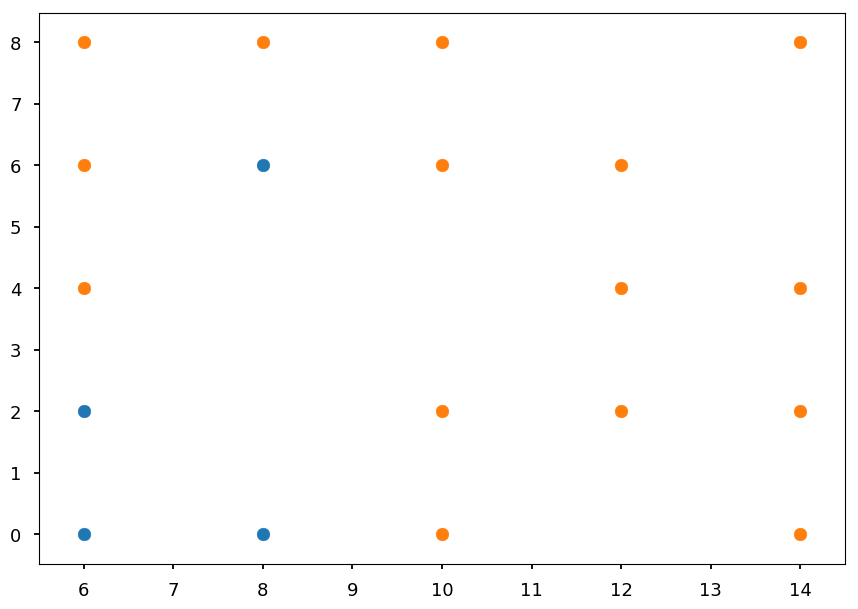

In [83]:
plt.xlim([5.5, 14.5])

plt.scatter(*blue_train.T)
plt.scatter(*orange_train.T);

* Check $x$ maximum information gain ratio

In [84]:
Nb = 4
No = 15

splits = {"6": (2, 3), "8": (4, 4), "10": (4, 8), "12": (4, 11)}

for threshold, (no, nb) in splits.items():
  print("Threshold = {}\t -> {}".format(threshold, info_gain(Nb, No, no, nb)))

Threshold = 6	 -> 0.051004839414443226
Threshold = 8	 -> 0.32143493796317624
Threshold = 10	 -> 0.16251125329718286
Threshold = 12	 -> 0.08198172064120202


In [85]:
print("Information gain ratio with x > 8:",
      info_gain(Nb, No, *splits["8"]) / entropy(5, 3, 4, 3, 4))

Information gain ratio with x > 8: 0.14010311259651076


* Check $y$ maximum information gain ratio

In [86]:
Nb = 4
No = 15

splits = {"0": (2, 2), "2": (3, 5), "4": (3, 6), "6": (4, 9)}

for threshold, (no, nb) in splits.items():
  print("Threshold = {}\t -> {}".format(threshold, info_gain(Nb, No, no, nb)))

Threshold = 0	 -> 0.08471690647404045
Threshold = 2	 -> 0.08617499693494635
Threshold = 4	 -> 0.06066554625879636
Threshold = 6	 -> 0.13320381570773476


In [88]:
print("Information gain ratio with y > 6:",
      info_gain(Nb, No, *splits["6"]) / entropy(4, 4, 3, 4, 4))

Information gain ratio with y > 6: 0.05757775370755489


* Once again $x$ is a winner

* And we have a new node

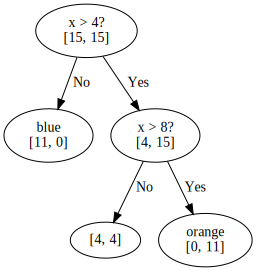

In [90]:
tree = Digraph()

tree.edge("x > 4?\n[15, 15]", "blue\n[11, 0]", "No")
tree.edge("x > 4?\n[15, 15]", "x > 8?\n[4, 15]", "Yes")

tree.edge("x > 8?\n[4, 15]", "[4, 4]", "No")
tree.edge("x > 8?\n[4, 15]", "orange\n[0, 11]", "Yes")

tree

#### Branch x<= 8

* We will continue until the tree is fully grown

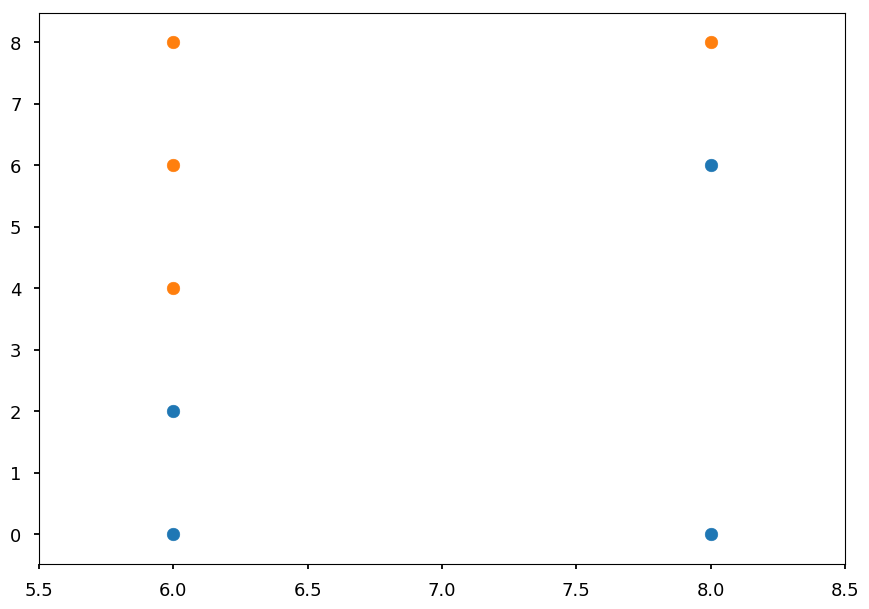

In [92]:
plt.xlim([5.5, 8.5])

plt.scatter(*blue_train.T)
plt.scatter(*orange_train.T);

* Again, the best cut may be pretty obvious, but lets check the math
* We have one possible cut in $x$

In [93]:
Nb = 4
No = 4

print("Information gain ratio with x > 6:",
      info_gain(Nb, No, 2, 3) / entropy(5, 3))

Information gain ratio with x > 6: 0.05112447853477686


* And usual threshold candidates in $y$

In [94]:
splits = {"0": (2, 0), "2": (3, 0), "4": (3, 1), "6": (4, 2)}

for threshold, (no, nb) in splits.items():
  print("Threshold = {}\t -> {}".format(threshold, info_gain(Nb, No, no, nb)))

Threshold = 0	 -> 0.31127812445913283
Threshold = 2	 -> 0.5487949406953986
Threshold = 4	 -> 0.1887218755408671
Threshold = 6	 -> 0.31127812445913283


In [95]:
print("Information gain ratio with y > 2:",
      info_gain(Nb, No, *splits["2"]) / entropy(2, 1, 1, 2, 2))

Information gain ratio with y > 2: 0.24390886253128827


* And the tree is growing

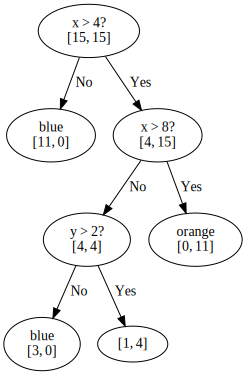

In [104]:
tree = Digraph()

tree.edge("x > 4?\n[15, 15]", "blue\n[11, 0]", "No")
tree.edge("x > 4?\n[15, 15]", "x > 8?\n[4, 15]", "Yes")

tree.edge("x > 8?\n[4, 15]", "y > 2?\n[4, 4]", "No")
tree.edge("x > 8?\n[4, 15]", "orange\n[0, 11]", "Yes")

tree.edge("y > 2?\n[4, 4]", "blue\n[3, 0]", "No")
tree.edge("y > 2?\n[4, 4]", "[1, 4]", "Yes")

tree

#### Branch y > 2

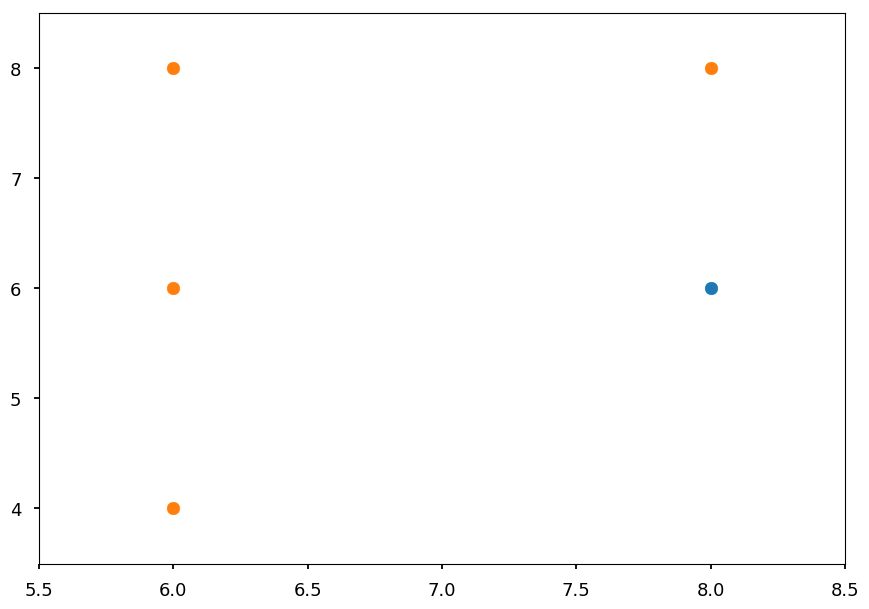

In [100]:
plt.xlim([5.5, 8.5])
plt.ylim([3.5, 8.5])

plt.scatter(*blue_train.T)
plt.scatter(*orange_train.T);

In [101]:
Nb = 1
No = 4

print("Information gain ratio with x > 6:",
      info_gain(Nb, No, 0, 3) / entropy(3, 2))

Information gain ratio with x > 6: 0.33155970728682876


In [103]:
print("Information gain ratio with y > 4:",
      info_gain(Nb, No, 0, 1) / entropy(1, 2, 2))

print("Information gain ratio with y > 6:",
      info_gain(Nb, No, 1, 2) / entropy(1, 2, 2))

Information gain ratio with y > 4: 0.047903442721748145
Information gain ratio with y > 6: 0.11232501392736344


#### The final tree

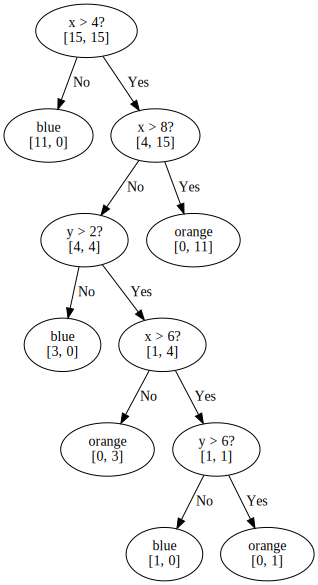

In [105]:
tree = Digraph()

tree.edge("x > 4?\n[15, 15]", "blue\n[11, 0]", "No")
tree.edge("x > 4?\n[15, 15]", "x > 8?\n[4, 15]", "Yes")

tree.edge("x > 8?\n[4, 15]", "y > 2?\n[4, 4]", "No")
tree.edge("x > 8?\n[4, 15]", "orange\n[0, 11]", "Yes")

tree.edge("y > 2?\n[4, 4]", "blue\n[3, 0]", "No")
tree.edge("y > 2?\n[4, 4]", "x > 6?\n[1, 4]", "Yes")

tree.edge("x > 6?\n[1, 4]", "orange\n[0, 3]", "No")
tree.edge("x > 6?\n[1, 4]", "y > 6?\n[1, 1]", "Yes")

tree.edge("y > 6?\n[1, 1]", "blue\n[1, 0]", "No")
tree.edge("y > 6?\n[1, 1]", "orange\n[0, 1]", "Yes")

tree

* It is likely that this tree is overfitted

* We will proceed with pruning as it was explained

* But first lets implement decision rules to measure accuracy

In [0]:
def tree_nominal(x, y):
  """Implementation of above tree"""
  if x <= 4:
    return "blue"
  elif x > 8:
    return "orange"
  elif y <= 2:
    return "blue"
  elif x <= 6:
    return "orange"
  else:
    return "orange" if y > 6 else "blue"

#### Sanity check

* If the tree is built *correctly* we expect 100% accuracy on training set

In [135]:
for x, y in blue_train:
  print(tree_nominal(x, y), end=' ')

blue blue blue blue blue blue blue blue blue blue blue blue blue blue blue 

In [136]:
for x, y in orange_train:
  print(tree_nominal(x, y), end=' ') 

orange orange orange orange orange orange orange orange orange orange orange orange orange orange orange 

#### Accuracy before pruning

In [0]:
def accuracy(samples, tree):
  """Just print the result of classification"""
  for x, y in samples:
    print("({}, {}) -> {}".format(x, y, tree(x, y)))

In [138]:
accuracy(blue_valid, tree_nominal)

(0, 6) -> blue
(2, 4) -> blue
(4, 0) -> blue
(4, 8) -> blue
(8, 2) -> blue


In [139]:
accuracy(orange_valid, tree)

(8, 4) -> blue
(10, 4) -> orange
(12, 0) -> orange
(12, 8) -> orange
(14, 6) -> orange


#### Pruning I

* We want to prune last decision node $y > 6$

* In general, majority decides about the leaf node class

* As it is a tie here, lets check both

In [0]:
def tree_prune01a(x, y):
  """Implementation of above tree"""
  if x <= 4:
    return "blue"
  elif x > 8:
    return "orange"
  elif y <= 2:
    return "blue"
  elif x <= 6:
    return "orange"
  else:
    return "blue"
  
def tree_prune01b(x, y):
  """Implementation of above tree"""
  if x <= 4:
    return "blue"
  elif x > 8:
    return "orange"
  elif y <= 2:
    return "blue"
  else:
    return "orange"

In [155]:
accuracy(blue_valid, tree_prune01a)

(0, 6) -> blue
(2, 4) -> blue
(4, 0) -> blue
(4, 8) -> blue
(8, 2) -> blue


In [156]:
accuracy(orange_valid, tree_prune01a)

(8, 4) -> blue
(10, 4) -> orange
(12, 0) -> orange
(12, 8) -> orange
(14, 6) -> orange


* Pruning does not change the accuracy

* We always use Occam's razor and `prune01a` is preferred over nominal tree

* But lets see how `prune01b` works

In [157]:
accuracy(blue_valid, tree_prune01b)

(0, 6) -> blue
(2, 4) -> blue
(4, 0) -> blue
(4, 8) -> blue
(8, 2) -> blue


In [158]:
accuracy(orange_valid, tree_prune01b)

(8, 4) -> orange
(10, 4) -> orange
(12, 0) -> orange
(12, 8) -> orange
(14, 6) -> orange


* In this case we even get the increase of the accuracy

* We decide to prune a tree by replacing $y > 6$ decision node with "orange" leaf node

* Which automatically removes $x > 6$ decision node

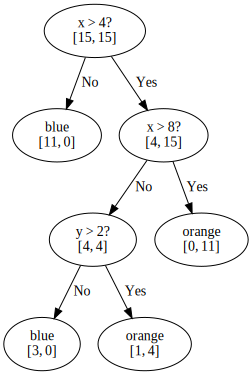

In [120]:
tree = Digraph()

tree.edge("x > 4?\n[15, 15]", "blue\n[11, 0]", "No")
tree.edge("x > 4?\n[15, 15]", "x > 8?\n[4, 15]", "Yes")

tree.edge("x > 8?\n[4, 15]", "y > 2?\n[4, 4]", "No")
tree.edge("x > 8?\n[4, 15]", "orange\n[0, 11]", "Yes")

tree.edge("y > 2?\n[4, 4]", "blue\n[3, 0]", "No")
tree.edge("y > 2?\n[4, 4]", "orange\n[1, 4]", "Yes")

tree

#### Pruning II

* Now, lets see the accuracy after removing $y > 2$ node

* It is once again a tie, so lets check both scenarios

In [0]:
def tree_prune02a(x, y):
  """Implementation of above tree"""
  if x <= 4:
    return "blue"
  else:
    return "orange"
  
def tree_prune02b(x, y):
  """Implementation of above tree"""
  if x <= 4:
    return "blue"
  elif x > 8:
    return "orange"
  else:
    return "blue"

In [150]:
accuracy(blue_valid, tree_prune02a)

(0, 6) -> blue
(2, 4) -> blue
(4, 0) -> blue
(4, 8) -> blue
(8, 2) -> orange


In [151]:
accuracy(orange_valid, tree_prune02a)

(8, 4) -> orange
(10, 4) -> orange
(12, 0) -> orange
(12, 8) -> orange
(14, 6) -> orange


In [152]:
accuracy(blue_valid, tree_prune02b)

(0, 6) -> blue
(2, 4) -> blue
(4, 0) -> blue
(4, 8) -> blue
(8, 2) -> blue


In [153]:
accuracy(orange_valid, tree_prune02b)

(8, 4) -> blue
(10, 4) -> orange
(12, 0) -> orange
(12, 8) -> orange
(14, 6) -> orange


* In both cases the error increased

* We stop pruning and leave the tree as it is in `prune01b` version 

#### Summary

* C4.5 algorithm gives the full and clear prescription for building decision trees

* It may look as a long procedure, but it is only because I wanted to show everything step by step and avoid *"after a few trivial steps..."*

* ID3/C4.5/C5.0 are based on information theory

* There is alternative procedure based on *gini impurity*, which is used by CART

## CART

## Gini impurity